# Omar Ali's Cube Submission

## Introduction ⚓
> I have chosen to go with the route of pre-parsing text for analysis using Rhetorical Structure Theory (RST). RST is a theory within text analysis I worked very closely with, that allows you to abstract text in a hierarchical fashion. This is done using a three stage process (Segmenting, Relationship generation and Tree generation). For the consideration of time, a well known RST parser (HILDA) will be used to carry our these stages. As the parser's implementation is fairly old, It has been contained by a wrapper using Docker. Therefore, I will preparse the text I will use in this work and output the findings into a folder for use in this Notebook. Streamlining this process will be explored at the end of this submission with further-work and improvements also explained.

> I have attached the pre-parsed data used in this submission. Please add it to the contents folder to run.

## Goal ⭐
> Overall, the main goal of my submission is to understand the language and structure that goes into Policy-definining documents. I will do so by creating a subset of the data for use in RST parsing. This will allow me to weight them and take the most important for use in training a transformer for binary classification. *Less important information taken from the dataset (Not related to policy enforcing) will be used as the second class.*

## Overview of Implementation 🕵

> For the consideration of time, I have pre-generated RST trees from a selection of instances within the provided dataset. In practice this would be scaled up to an automated generation cycle per instance whereby, for each instance added to the database, and RST tree would be generated.
> 
> For each instance, the RST tree would be weighted with the most important parts considered highly above the less important sections. Following a similar model to text summarisation, the least important aspects will be removed.
> 
> With the most important parts identified we can train a model to determine what features are present within topics that are indicative of emerging changes required by policymakers. This model allows for our analysis to be scaled to different instances that are coming through every day. 
> 
> The hypothesis is that there is some level of consistency within information indicative of a policy change. I hope that the added level of rhetorical structure theory and its segmentation will allow for these parts to be highlighted and learned from.
> 
> In future, I may also consider using the relationships between spans of text as an indication to emerging policies. For example relationships that represent attributions or cause-and-effect might likely be an indication of emerging changes to policy.

## Implementation
1. Weighting logic to rank our RST trees
2. Data taken from the data set processes using HILDA (and RST parser)

Output:
1. Ranked, indexed list of the most important, salient points taken from the text that are likely to indicate policy changes.

### Importing dependencies needed

In [ ]:
!pip install transformers
!pip install beautifulsoup4

### 1) Extracting Text From the Embedded HTML
This code snippet is used to extract text taken from the smaller dataset created. For clarity, this dataset included Policy related items. The outputs from the data are parsed using the RST parser. This is done outside of the notebook as I dodn't have enough time to create an implementation of the parser such that it was entirely self contained.

In [3]:
from google.colab import auth
auth.authenticate_user()
import csv
import gspread
import pandas as pd
import os
from bs4 import BeautifulSoup

# Authorisation for google to access the data.
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

worksheet = gc.open('cube_smaller_dataset_policy_learning').sheet1
rows = worksheet.get_all_values()
cube_policy_data_raw = pd.DataFrame.from_records(rows, columns=['issurance_type', 'text'])

output_file_data = ""
# Reading the data

# filter_by_issurance_type = ['Policy', 'Policy Statement', 'Paper']
filter_by_issurance_type = [ 'Paper']

file_index = 0
# Create the RST Inputs folder for use in the HILDA parser.
try:
    os.mkdir('rst_inputs')
except:
    print ("File already exists. Continuing...")
for index, rows in cube_policy_data_raw.iterrows():
    raw_text = rows['text']
    issurance_type = rows['issurance_type']
    if issurance_type not in filter_by_issurance_type:
        continue
    soup = BeautifulSoup(raw_text, features="html.parser")
    for script in soup(["script", "style"]):
        script.extract()
    extracted_text = soup.getText()
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    for chunk in chunks:
        if chunk:
            output_file_data += f"{text}"
            with open(f'rst_inputs/input_{file_index}.txt', 'w') as output_file:
                output_file.write(output_file_data)
                output_file.close()
            file_index += 1


File already exists. Continuing...


### RST Ranker Logic
This Section of the code aims to rank EDUs based on their importance with the text. Text must first be processed using HILDA and stored.

In [5]:
import csv
import re 
import json
def convert_str_RST_to_tup(rst_str = None):
    rst_str = rst_str.replace('ParseTree', '')
    print (rst_str)
    rst_str = eval(rst_str)
    return rst_str

w = []
# The two weighting schemes defined. HEAVY removes all SATELITES
# (think text summerization), LIGHT only intensifies and subdues NUC's and SAT's.

HEAVY = (1, 0)      # This weighting scheme will simply remove any significants of satelliting spans.
LIGHT = (1.5, 0.5)  # This weighting scheme will add 50% to the nuclei, and subtract 50% from thr satellites.
STAGE_2 = (1, 1)    # THis weighting scheme will preserve the natural weights formed from the tree.

# Recursively weight the the tuple-tree (nested tuples). 
def weight_RST(weights, tup_obj, weight=1, weighting_scheme=LIGHT):
    # print ("Begin Weighting Process....")
    NUC = '[N]'
    SAT = '[S]'
    NA  = 'n/a'
    relation = tup_obj[0]
    subtree = tup_obj[1]
    relation_type = re.findall(r'\[[a-zA-Z]\]', relation)

    if relation == NA:
        weights.append([subtree[0], weighting_scheme[0]])
        return

    if isinstance(subtree[0], str):
        if relation_type[0] == NUC:
            weights.append ([subtree[0], weight*weighting_scheme[0]])
        if relation_type[0] == SAT:
            weights.append ([subtree[0], weight*weighting_scheme[1]])
    if isinstance(subtree[1], str):
        if relation_type[1] == NUC:
            weights.append ([subtree[1], weight*weighting_scheme[0]])
        if relation_type[1] == SAT:
            weights.append ([subtree[1], weight*weighting_scheme[1]])
    if isinstance(subtree[1], tuple):
        if relation_type[1] == NUC:
            weight_RST(weights, subtree[1], weight*weighting_scheme[0])
        if relation_type[1] == SAT:
            weight_RST(weights, subtree[1], weight*weighting_scheme[1])
    if isinstance(subtree[0], tuple):
        if relation_type[0] == NUC:
            weight_RST(weights, subtree[0], weight*weighting_scheme[0])
        if relation_type[0] == SAT:
            weight_RST(weights, subtree[0], weight*weighting_scheme[1])
    # print ("FINISHED Weighting Process....")

### Weight and Train Model
> This section takes our RST outputs generated from HILDA (RST Parser) and weights the most important parts by means of a weighting scheme.
>
> The weighting scheme determines how the nucleus (Most important span) and its satellite (The sumplimentary span) is weighted.
>
> Traditionally, the weighting scheme used is (1.5, 0.5) whereby, more important spans are weighted 50% more, and the less importanted spans' importance is halved.

In [ ]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
directory = 'rst_outputs'
input_rst_files = [f for f in listdir(directory) if isfile(join(directory, f))]

for input_file in input_rst_files:
    input_dir = join(directory, input_file)
    
    with open(input_dir, 'r') as input_rst_file:
        contents = input_rst_file.read()
        w = []
        to_RST = convert_str_RST_to_tup(contents)
        weight_RST(w, to_RST)
        w.sort (key=lambda a: a[1], reverse=True)
        # INCREASE THIS NUMBER TO INTRODUCE MORE SPANS IN THE OUTPUT
        w = w[:3]
        print (len(w))
        plot_x, plot_y = [], []
        for EDUS in w:
            plot_x.append(EDUS[0])
            plot_y.append(EDUS[1])
        
        plt.xticks(rotation=90)
        plt.bar(plot_x, plot_y, color='green')
        


### Representation of outputs

> Below is a graph that describes which parts of the text are the most important for each instance.
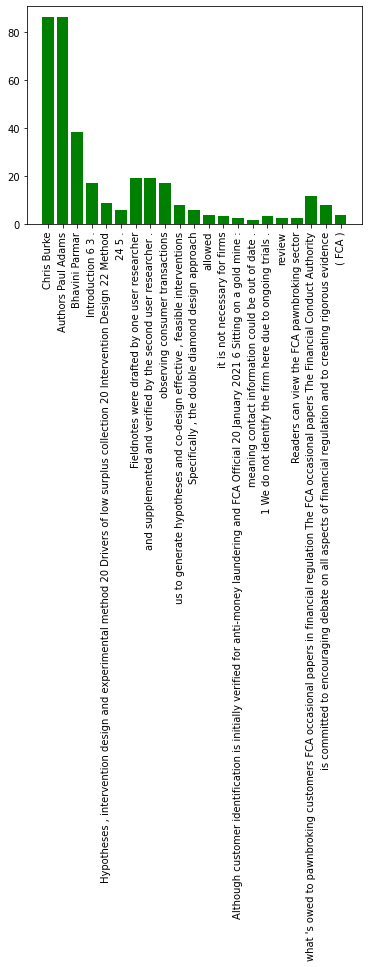

> From this representation we can threshold the data and obtain the features of the paper that are the most pivotal or important.
> This information can be saved for use in either model training or simply stored in a CSV with their ranks/weights for use in detecting policy-changing works.

### Summary and Conclusions
I was only able to process one paper due to the size of the data. I wanted to focus on providing a PoC in this submission, rather than a broader stream that was able to crunch through each instance in the provided dataset. The information found in the paper was feature rich, and only a few select papers would be needed to obtain enough features to begin training. A demonstration of this can be seen if you increase the number on line labeled `# INCREASE THIS NUMBER TO INTRODUCE MORE SPANS IN THE OUTPUT`.

### Further work and Improvements
**Training a Model**
I wanted to demonstrate what kind of information (from your provided dataset) could be extracted using RST. If I had more time, I would have trained a simple transformer to begin identifing other instances/works that may indicate policy changing features.

**Challenges**
1. *The first main challenge was understanding the data in such a way that I could quickly figure out which parts would be most useful in the PoC.* 

    Given more time, I would like to extract other parts of the data provided and explore other uses for it (beyond RegBrain and RegInsight). I find that extra-curricular activies such as these help me to better wrap my head around the possibilities.

2. *Streamlining and automating RST parsing.* Ideally, when new instances are inserted into this dataset, their RST counterpart would be automatically generated and embedded.

**Improvements**
As i focused mainly on proving what RST can do in this case, I didn't spend much time pre-processing the information from the dataset beyond parsing the HTML and extracting the contents. In the future, I would like to break down the information within papers and policies into more digestable chucks to be further processes using RST. 
Moreover, running the RST parser on a much more powerful computer than my laptop would circumvent the need for pre-digesting the data.